In [1]:
import ee
import geemap
import pandas as pd
import json
import os

# GEE kimlik doğrulama ve proje kimliği ile başlatma
project_id = 'ee-turelhaticezehra'

# İlk seferde kimlik doğrulama işlemi yapılmalı
ee.Authenticate()

# GEE başlatma işlemi proje kimliği ile birlikte
ee.Initialize(project='ee-turelhaticezehra')

# Program başladığını belirt
print("Program başladı, işlemler devam ediyor...")

# İl ve ilçe sınırlarının yüklenmesi
with open('provinces.json', encoding='utf-8') as f:
    provinces_geojson = json.load(f)

# Bartın ili sınırlarını seç (Bartın'ı kontrol etmek için doğru şekilde yazıldığından emin olun)
bartin_province = [
    feature for feature in provinces_geojson['features']
    if feature['properties']['NAME_1'] == 'Bartın'  # Burada büyük/küçük harfe duyarlı eşleme kullanıyoruz
]

# Bartın ili verisini bulamazsanız hata mesajı göster
if not bartin_province:
    print("Bartın ili verisi bulunamadı. Lütfen 'provinces.json' dosyasını kontrol edin.")
else:
    # Bartın ili sınırlarını al
    bartin_province = bartin_province[0]  # Bartın ilini tek bir özellik olarak alıyoruz

    # Tarih ve bulut filtresi parametreleri
    date_ranges = [
    {'start': '2016-01-01', 'end': '2016-03-31', 'cloud': 10},
    {'start': '2016-04-01', 'end': '2016-06-30', 'cloud': 10},
    {'start': '2016-07-01', 'end': '2016-09-30', 'cloud': 10},
    {'start': '2016-10-01', 'end': '2016-12-31', 'cloud': 10},
    
    {'start': '2017-01-01', 'end': '2017-03-31', 'cloud': 10},
    {'start': '2017-04-01', 'end': '2017-06-30', 'cloud': 10},
    {'start': '2017-07-01', 'end': '2017-09-30', 'cloud': 10},
    {'start': '2017-10-01', 'end': '2017-12-31', 'cloud': 10},
    
    {'start': '2018-01-01', 'end': '2018-03-31', 'cloud': 10},
    {'start': '2018-04-01', 'end': '2018-06-30', 'cloud': 10},
    {'start': '2018-07-01', 'end': '2018-09-30', 'cloud': 10},
    {'start': '2018-10-01', 'end': '2018-12-31', 'cloud': 10},
    
    {'start': '2019-01-01', 'end': '2019-03-31', 'cloud': 10},
    {'start': '2019-04-01', 'end': '2019-06-30', 'cloud': 10},
    {'start': '2019-07-01', 'end': '2019-09-30', 'cloud': 10},
    {'start': '2019-10-01', 'end': '2019-12-31', 'cloud': 10},
    
    {'start': '2020-01-01', 'end': '2020-03-31', 'cloud': 10},
    {'start': '2020-04-01', 'end': '2020-06-30', 'cloud': 10},
    {'start': '2020-07-01', 'end': '2020-09-30', 'cloud': 10},
    {'start': '2020-10-01', 'end': '2020-12-31', 'cloud': 10},
    
    {'start': '2021-01-01', 'end': '2021-03-31', 'cloud': 10},
    {'start': '2021-04-01', 'end': '2021-06-30', 'cloud': 10},
    {'start': '2021-07-01', 'end': '2021-09-30', 'cloud': 10},
    {'start': '2021-10-01', 'end': '2021-12-31', 'cloud': 10},
    
    {'start': '2022-01-01', 'end': '2022-03-31', 'cloud': 10},
    {'start': '2022-04-01', 'end': '2022-06-30', 'cloud': 10},
    {'start': '2022-07-01', 'end': '2022-09-30', 'cloud': 10},
    {'start': '2022-10-01', 'end': '2022-12-31', 'cloud': 10},
    
    {'start': '2023-01-01', 'end': '2023-03-31', 'cloud': 10},
    {'start': '2023-04-01', 'end': '2023-06-30', 'cloud': 10},
    {'start': '2023-07-01', 'end': '2023-09-30', 'cloud': 10},
    {'start': '2023-10-01', 'end': '2023-12-31', 'cloud': 10},
    
    {'start': '2024-01-01', 'end': '2024-03-31', 'cloud': 10},
    {'start': '2024-04-01', 'end': '2024-06-30', 'cloud': 10},
    {'start': '2024-07-01', 'end': '2024-09-30', 'cloud': 10},
    {'start': '2024-10-01', 'end': '2024-12-31', 'cloud': 10},
]


    # NDVI eşik değerleri (Yeşil alan tanımı için NDVI > 0.2)
    ndvi_threshold = 0.2
    pixel_area = 30 * 30  # Sentinel-2 piksel boyutu: 30m x 30m (m²)

    # Çıktı dosyası adı
    output_csv = 'ndvi_results_bartin_sadeceil.csv'

    # Eğer dosya mevcutsa yükle, yoksa başlat
    if os.path.exists(output_csv):
        ndvi_df = pd.read_csv(output_csv)
        print(f"Var olan {output_csv} dosyası yüklendi.")
    else:
        ndvi_df = pd.DataFrame(columns=['year', 'province', 'mean_ndvi', 'total_green_area_ha'])
        print(f"Yeni {output_csv} dosyası oluşturuldu.")

    # Bartın ili için NDVI hesaplama
    print("Bartın ili için işlem başlıyor...")
    bartin_geometry = ee.Feature(ee.Geometry.MultiPolygon(bartin_province['geometry']['coordinates']))

    for date_range in date_ranges:
        print(f"Bartın ili için {date_range['start']} ile {date_range['end']} tarih aralığı işleniyor...")
        sentinel_collection = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
            .filterBounds(bartin_geometry.geometry()) \
            .filterDate(date_range['start'], date_range['end']) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', date_range['cloud']))
        
        # Eğer uygun görüntü bulunamazsa, bir sonraki tarih aralığına geç
        if sentinel_collection.size().getInfo() == 0:
            print(f"Bartın ili için {date_range['start']} ile {date_range['end']} tarih aralığında veri bulunamadı, sonraki tarih aralığına geçiliyor...")
            continue
        
        sentinel_mosaic = sentinel_collection.median().clip(bartin_geometry.geometry())
        ndvi = sentinel_mosaic.normalizedDifference(['B8', 'B4']).rename('NDVI')
        
        green_area = ndvi.gt(ndvi_threshold).multiply(pixel_area).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=bartin_geometry.geometry(),
            scale=30,
            maxPixels=1e13
        ).get('NDVI').getInfo()
        
        if green_area is None:
            green_area = 0
        
        mean_ndvi = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=bartin_geometry.geometry(),
            scale=30,
            maxPixels=1e13
        ).get('NDVI').getInfo()
        
        if mean_ndvi is None:
            mean_ndvi = 0 # Eğer yeşil alan yoksa sıfırla
        
        new_data = {
            'year': date_range['start'][:4],
            'province': "Bartın",
            'mean_ndvi': mean_ndvi,
            'total_green_area_ha': green_area / 1e4  # m² -> hektar
        }
        ndvi_df = pd.concat([ndvi_df, pd.DataFrame([new_data])], ignore_index=True)
        ndvi_df.to_csv(output_csv, index=False)  # CSV'yi her adımda güncelle
        print(f"Bartın ili için {date_range['start']} ile {date_range['end']} tarih aralığı sonuçları kaydedildi.")

    print("Bartın ili için NDVI analizleri tamamlandı ve sonuçlar kaydedildi.")


Program başladı, işlemler devam ediyor...
Yeni ndvi_results_bartin_sadeceil.csv dosyası oluşturuldu.
Bartın ili için işlem başlıyor...
Bartın ili için 2016-01-01 ile 2016-03-31 tarih aralığı işleniyor...
Bartın ili için 2016-01-01 ile 2016-03-31 tarih aralığı sonuçları kaydedildi.
Bartın ili için 2016-04-01 ile 2016-06-30 tarih aralığı işleniyor...
Bartın ili için 2016-04-01 ile 2016-06-30 tarih aralığı sonuçları kaydedildi.
Bartın ili için 2016-07-01 ile 2016-09-30 tarih aralığı işleniyor...
Bartın ili için 2016-07-01 ile 2016-09-30 tarih aralığı sonuçları kaydedildi.
Bartın ili için 2016-10-01 ile 2016-12-31 tarih aralığı işleniyor...
Bartın ili için 2016-10-01 ile 2016-12-31 tarih aralığı sonuçları kaydedildi.
Bartın ili için 2017-01-01 ile 2017-03-31 tarih aralığı işleniyor...
Bartın ili için 2017-01-01 ile 2017-03-31 tarih aralığı sonuçları kaydedildi.
Bartın ili için 2017-04-01 ile 2017-06-30 tarih aralığı işleniyor...
Bartın ili için 2017-04-01 ile 2017-06-30 tarih aralığı sonuç

Eksik (NaN) Değerler:
year                   0
province               0
mean_ndvi              0
total_green_area_ha    0
dtype: int64

Sonsuz Değerler:
year                   0
mean_ndvi              0
total_green_area_ha    0
dtype: int64
Hiperparametre optimizasyonu başlıyor...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
En iyi parametreler: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Model performans sonuçları:
Mean Absolute Error (MAE): 881.32
Mean Squared Error (MSE): 1283415.91
Root Mean Squared Error (RMSE): 1132.88
R2 Score: 0.96


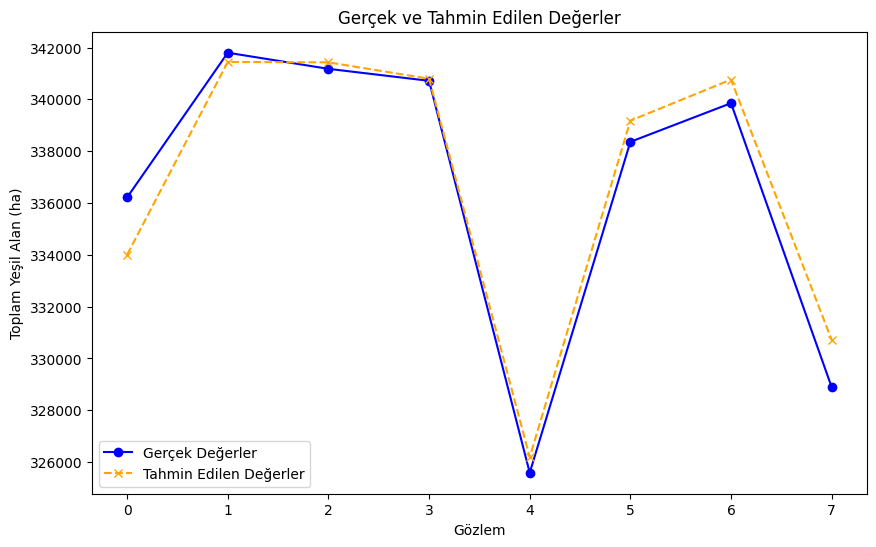

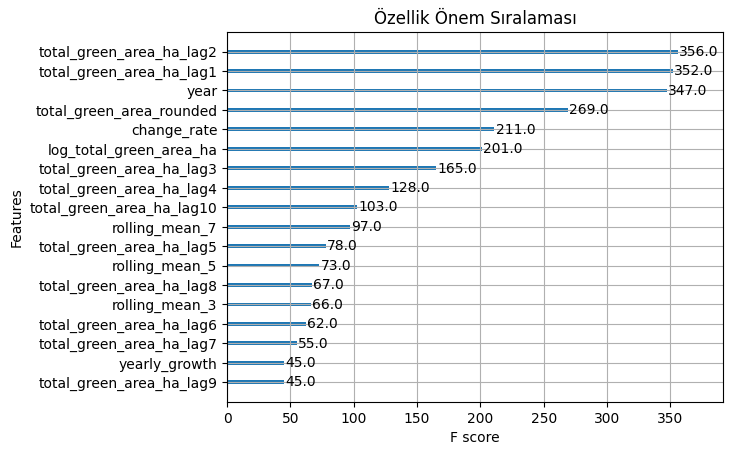

Tahminler 'xgboost_optimized_predictions_bartin.csv' olarak kaydedildi.
2025-2030 yılları için tahminler 'xgboost_optimized_predictions_2025_2030_bartin.csv' olarak kaydedildi.


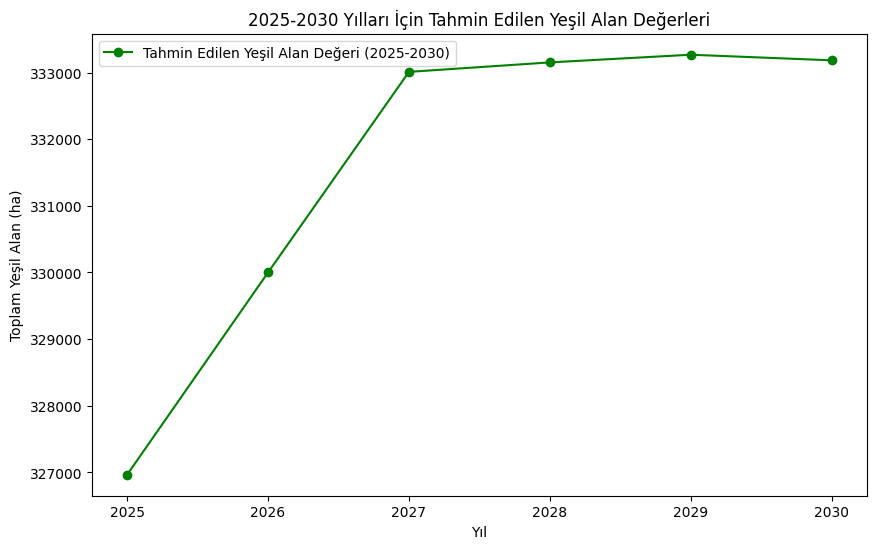

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Veri setini yükleme
data = pd.read_csv("ndvi_results_bartin_sadeceil.csv")

# Verinin eksik (NaN) ve sonsuz (Infinity) değerlerini kontrol etme
print("Eksik (NaN) Değerler:")
print(data.isna().sum())

# Sonsuz (Infinity) Değerleri kontrol etme
print("\nSonsuz Değerler:")
print(np.isinf(data.select_dtypes(include=[np.number])).sum())  # sadece sayısal verileri kontrol et

# NaN ve Sonsuz Değerleri Düzeltme
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.fillna(method='ffill').fillna(method='bfill')  # Eksik (NaN) değerleri doldur

# Gecikmeli (lag) özellikler ekleme (10 lag özelliği)
for lag in range(1, 11):
    data[f'total_green_area_ha_lag{lag}'] = data['total_green_area_ha'].shift(lag)

# Hareketli Ortalama (Rolling Mean) ekleme (3, 5, 7 yıllık)
for window in [3, 5, 7]:
    data[f'rolling_mean_{window}'] = data['total_green_area_ha'].rolling(window=window).mean()

# Yeşil alan değişim oranını hesaplama
data['change_rate'] = data['total_green_area_ha'].pct_change()

# Yıllık büyüme oranı hesaplama
data['yearly_growth'] = data['total_green_area_ha'] / data['total_green_area_ha_lag1'] - 1

# Yuvarlatılmış yeşil alan ekleme
data['total_green_area_rounded'] = data['total_green_area_ha'].apply(lambda x: round(x, -3))

# Logarithmic dönüşüm ekleme (yeşil alan)
data['log_total_green_area_ha'] = np.log1p(data['total_green_area_ha'])

# Eksik değerleri doldurma (forward fill ve backward fill)
data = data.fillna(method='ffill').fillna(method='bfill')

# Hedef ve özellikler
target = 'total_green_area_ha'
features = ['year']
# Tüm lag özelliklerini ekliyoruz
for lag in range(1, 11):
    features.append(f'total_green_area_ha_lag{lag}')
features += ['change_rate', 'yearly_growth', 'total_green_area_rounded', 'log_total_green_area_ha']
# Hareketli ortalamaları da ekliyoruz
for window in [3, 5, 7]:
    features.append(f'rolling_mean_{window}')

X = data[features]
y = data[target]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost modelini tanımlama
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hiperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
print("Hiperparametre optimizasyonu başlıyor...")
grid_search.fit(X_train, y_train)

# En iyi parametrelerle modeli eğitme
best_model = grid_search.best_estimator_
print("En iyi parametreler:", grid_search.best_params_)

# Test seti üzerinde tahmin
y_pred = best_model.predict(X_test)

# Performans değerlendirme
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model performans sonuçları:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Gerçek ve tahmin edilen değerleri görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Gerçek Değerler", color='blue', marker='o')
plt.plot(y_pred, label="Tahmin Edilen Değerler", color='orange', linestyle='--', marker='x')
plt.title("Gerçek ve Tahmin Edilen Değerler")
plt.xlabel("Gözlem")
plt.ylabel("Toplam Yeşil Alan (ha)")
plt.legend()
plt.show()

# Özellik önem sıralaması
xgb.plot_importance(best_model, importance_type='weight', title="Özellik Önem Sıralaması")
plt.show()

# Tahminleri yeni bir dosyaya kaydetme
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.to_csv("xgboost_optimized_predictions_bartin.csv", index=False)
print("Tahminler 'xgboost_optimized_predictions_bartin.csv' olarak kaydedildi.")

# 2025-2030 yılları için tahminler
# Yeni yıllar için veri oluşturma (2025-2030)
future_years = pd.DataFrame({'year': range(2025, 2031)})

# İlk yıl için 'total_green_area_ha' değeri başlangıç olarak atanacak
last_known_value = data['total_green_area_ha'].iloc[-1]  # Son bilinen yeşil alan değeri
future_years['total_green_area_ha'] = last_known_value  # Tüm yıllara bu değeri atıyoruz

# Lag özelliklerini ve hareketli ortalamaları eklemek
for lag in range(1, 11):
    future_years[f'total_green_area_ha_lag{lag}'] = np.nan  # Yeni yıllar için NaN ekleyelim

for window in [3, 5, 7]:
    future_years[f'rolling_mean_{window}'] = np.nan  # Yeni yıllar için NaN ekleyelim

# Lag özelliklerini dinamik hesaplama (geçmiş verileri ile)
for i in range(1, len(future_years)):
    future_years.loc[i, 'total_green_area_ha_lag1'] = future_years.loc[i-1, 'total_green_area_ha']
    
    for lag in range(2, 11):
        if i-lag >= 0:  # i-lag negatif olmasın
            future_years.loc[i, f'total_green_area_ha_lag{lag}'] = future_years.loc[i-lag, 'total_green_area_ha']

# Hareketli Ortalama (Rolling Mean) hesaplama
for window in [3, 5, 7]:
    future_years[f'rolling_mean_{window}'] = np.nan
    for i in range(len(future_years)):
        if i >= window - 1:
            future_years.loc[i, f'rolling_mean_{window}'] = future_years.iloc[i-window+1:i+1]['total_green_area_ha'].mean()

# Change Rate ve Yearly Growth hesaplamaları
for i in range(1, len(future_years)):
    future_years.loc[i, 'change_rate'] = (future_years.loc[i, 'total_green_area_ha'] - future_years.loc[i-1, 'total_green_area_ha']) / future_years.loc[i-1, 'total_green_area_ha']
    future_years.loc[i, 'yearly_growth'] = (future_years.loc[i, 'total_green_area_ha'] / future_years.loc[i-1, 'total_green_area_ha']) - 1

# Yuvarlanmış yeşil alan ve logaritmik dönüşüm
for i in range(len(future_years)):
    future_years.loc[i, 'total_green_area_rounded'] = round(future_years.loc[i, 'total_green_area_ha'], -3)
    future_years.loc[i, 'log_total_green_area_ha'] = np.log1p(future_years.loc[i, 'total_green_area_ha'])

# Yeni verilerle tahmin yapma
X_future = future_years[features]  # Aynı özellikler kullanılarak tahmin yapılacak

# Tahminler
future_predictions = best_model.predict(X_future)

# Tahmin sonuçlarını gösterme
future_years['predicted_total_green_area_ha'] = future_predictions

# Sonuçları görselleştirme ve grafiği kaydetme
plt.figure(figsize=(10, 6))
plt.plot(future_years['year'], future_years['predicted_total_green_area_ha'], label="Tahmin Edilen Yeşil Alan Değeri (2025-2030)", color='green', marker='o')
plt.title("2025-2030 Yılları İçin Tahmin Edilen Yeşil Alan Değerleri")
plt.xlabel("Yıl")
plt.ylabel("Toplam Yeşil Alan (ha)")
plt.legend()

# Grafiği PNG olarak kaydetme
graph_path = "static/green_area_predictions_2025_2030.png"
plt.savefig(graph_path)

# Sonuçları kaydetme
future_years.to_csv("xgboost_optimized_predictions_2025_2030_bartin.csv", index=False)
print("2025-2030 yılları için tahminler 'xgboost_optimized_predictions_2025_2030_bartin.csv' olarak kaydedildi.")
